In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import PIL
import keras
import os
import numpy as np
import pandas as pd
import cv2
import random 
import itertools
import tensorflow as tf

from keras import utils as np_utils
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from PIL import Image, ImageOps
from numpy import expand_dims
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from google.colab.patches import cv2_imshow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications import EfficientNetB0
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix



In [3]:
bird_class = pd.read_excel('/content/gdrive/MyDrive/DSCI552_Final/Data/Classes.xlsx')
y = OneHotEncoder().fit_transform(bird_class).toarray()

In [4]:
subdir = []
path = os.getcwd()
path = os.path.join(path,'/content/gdrive/MyDrive/DSCI552_Final/Data/images')

for folder in os.listdir(path):
  fullpath = os.path.join(path, folder)
  if folder.endswith('.DS_Store'): 
      pass
  else:
    subdir.append(fullpath)   

Data Exploration and Pre-processing

In [6]:
#Split data: 70% train, 15% test, 15% validate
train_path = []
val_path = []
test_path = []
desired_size = 224

for each_folder in subdir:
  data_path_list = []
  for file in os.listdir(each_folder):
    path = os.path.join(each_folder, file)
    newPath = path.replace(os.sep, '/')
    data_path_list.append(newPath)

    image = cv2.imread(newPath)
    # image = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    image = cv2.resize(image, (224,224)) 
    cv2.imwrite(newPath,image)
    
  data = pd.DataFrame(data_path_list)
  train, validate, test = np.split(data.sample(frac=1, random_state=25), [int(.7*len(data)), int(.85*len(data))])
  train_path.append(train[0].values.tolist())
  val_path.append(validate[0].values.tolist())
  test_path.append(validate[0].values.tolist())

train_path = list(itertools.chain(*train_path))
val_path = list(itertools.chain(*val_path))
test_path = list(itertools.chain(*test_path))

In [7]:
train_path[0]
image = cv2.imread(train_path[0])
image.shape

(224, 224, 3)

In [8]:
bird_class = pd.read_excel('/content/gdrive/MyDrive/DSCI552_Final/Data/Classes.xlsx')
bird_class = bird_class.rename(columns = {"Folder Name ": "Folder"})
bird_class = bird_class.drop(columns = "Class")
y = OneHotEncoder().fit_transform(bird_class).toarray()

In [9]:
final_train_list = []
final_test_list = []
final_val_list = []
def resize_onehot(path):
  final_list = []
  for each_image_path in path:
    for index, row in bird_class.iterrows():
      if row["Folder"] in each_image_path:
        im = cv2.imread(each_image_path)
        final_list.append([im, y[index]])
  return final_list

final_train_list = resize_onehot(train_path)
final_test_list = resize_onehot(test_path)
final_val_list = resize_onehot(val_path)

In [10]:
len(final_train_list)

820

In [34]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for each in final_train_list:
  x_train.append(each[0])
  y_train.append(each[1])
for each in final_test_list:
  x_test.append(each[0])
  y_test.append(each[1])
for each in final_val_list:
  x_val.append(each[0])
  y_val.append(each[1])


In [12]:
len(x_train)

820

In [13]:
#Rotation
def rotation(each_path):
  image = cv2.imread(each_path)
  height, width = image.shape[:2]
  center = (width/2, height/2)

  rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=45, scale=1)
  rotated_image = cv2.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))

  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(rotated_image)
      y_train.append(y[index])
      final_train_list.append([rotated_image, y[index]])

In [14]:
#Translate
def translate(each_path):
  image = cv2.imread(each_path)
  height, width = image.shape[:2]
  tx, ty = width / 4, height / 4
  translation_matrix = np.array([
      [1, 0, tx],
      [0, 1, ty]
  ], dtype=np.float32)
  translated_image = cv2.warpAffine(src=image, M=translation_matrix, dsize=(width, height))

  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(translated_image)
      y_train.append(y[index])
      final_train_list.append([translated_image, y[index]])


In [15]:
#Crop
desired_size = 224
def crop(each_path):
  img = cv2.imread(each_path)
  cropped_image = img[50:174, 50:174]
  cropped_image = cv2.resize(cropped_image, (224,224)) 

  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(cropped_image)
      y_train.append(y[index])
      final_train_list.append([cropped_image, y[index]])

In [16]:
#Randomly zoom
def zoom(each_path):
  image = load_img(each_path)
  dataImage = img_to_array(image)
  imageNew = expand_dims(dataImage, 0)

  imageDataGen = ImageDataGenerator(zoom_range=[0.7,1.0])
  iterator = imageDataGen.flow(imageNew, batch_size=1)
  batch = iterator.next()
  image = batch[0].astype('uint8')

  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(image)
      y_train.append(y[index])
      final_train_list.append([image, y[index]])

In [17]:
#flip
def flip(each_path):
  img = cv2.imread(each_path)
  vertical_img = cv2.flip(img, 0)
  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(vertical_img)
      y_train.append(y[index])
      final_train_list.append([vertical_img, y[index]])

In [18]:
#Contrast
def contrast(each_path):
  img = cv2.imread(each_path)
  lab = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
  l_channel, a, b = cv2.split(lab)

  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  cl = clahe.apply(l_channel)

  limg = cv2.merge((cl,a,b))
  enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR) 

  for index, row in bird_class.iterrows():
    if row["Folder"] in each_path:
      x_train.append(enhanced_img)
      y_train.append(y[index])
      final_train_list.append([enhanced_img, y[index]])

In [19]:
for each_path in train_path:
  k_num = random.randint(1,6)
  aug = (rotation, translate, crop, zoom, flip, contrast)
  aug_list = random.choices(aug, k=6)
  for each_aug in aug_list:
    each_aug(each_path)

In [20]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [21]:
len(x_train)

5740

Use ReLU activation functions in the last layer and a softmax layer, along
with batch normalization
4
and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size,
but a batch size of 5 seems reasonable

In [22]:
base_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',pooling='avg',classes=20)

58889256/58889256 [==============================] - 0s 0us/step


In [23]:
model = keras.Sequential()
model.add(base_model)
for layer in model.layers[:]:
    layer.trainable = False

# model.add(keras.layers.Dense(20, activation=('relu')))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())

# model.add(keras.layers.Dense(20, activation=('relu')))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(20, activation=('relu')))
model.add(keras.layers.Dense(20, activation=('softmax')))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.build(input_shape=(224,224,3))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 20)                10260     
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                        

In [25]:
x_train = tf.stack(x_train)
y_train = tf.stack(y_train)
x_val = tf.stack(x_val)
y_val = tf.stack(y_val)
x_train1 = tf.keras.applications.vgg16.preprocess_input(x_train)

initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

In [26]:
hist = model.fit(np.array(x_train1), np.array(y_train), validation_data=(x_val,y_val), epochs=50, 
                 callbacks = [checkpoint,early, keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=1)], batch_size = 25)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/50
230/230 [==============================] - ETA: 0s - loss: 3.2008 - accuracy: 0.0660
Epoch 1: val_accuracy improved from -inf to 0.08427, saving model to vgg16_1.h5
230/230 [==============================] - 43s 142ms/step - loss: 3.2008 - accuracy: 0.0660 - val_loss: 3.1610 - val_accuracy: 0.0843 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.998999847394012e-05.
Epoch 2/50
230/230 [==============================] - ETA: 0s - loss: 2.8222 - accuracy: 0.1425
Epoch 2: val_accuracy improved from 0.08427 to 0.19101, saving model to vgg16_1.h5
230/230 [==============================] - 31s 134ms/step - loss: 2.8222 - accuracy: 0.1425 - val_loss: 2.7314 - val_accuracy: 0.1910 - lr: 9.9990e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.997000630676428e-05.
Epoch 3/50
230/230 [==============================] - ETA: 0s - loss: 2.5498 - accuracy: 0.2247
Epoch 3

6/6 [==============================] - 3s 509ms/step - loss: 0.5937 - accuracy: 0.8090
Train: 0.951, Test: 0.809


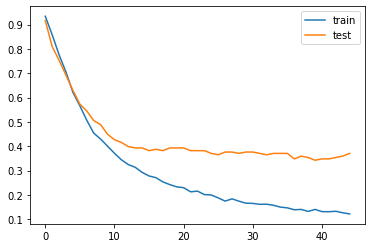

In [27]:
x_test = tf.stack(x_test)
x_test1 = tf.keras.applications.vgg16.preprocess_input(x_test)
y_test = tf.stack(y_test)

# evaluate the model
_, train_acc = model.evaluate(x_train1, y_train, verbose=1)
_, test_acc = model.evaluate(x_test1, y_test, verbose=1)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
train_error = []
test_error = []

for accuracy in hist.history["accuracy"]:
    train_error.append(1-accuracy)
for accuracy in hist.history["val_accuracy"]:
    test_error.append(1-accuracy)

# plot training history
pyplot.plot(train_error , label='train')
pyplot.plot(test_error, label='test')
pyplot.legend()
pyplot.show()

In [29]:
y_pred=model.predict(x_test1) 
y_pred=np.argmax(y_pred, axis=1)
y_test2=np.argmax(y_test, axis=1)

print(confusion_matrix(y_test2, y_pred))
print(classification_report(y_test2, y_pred))


6/6 [==============================] - 1s 155ms/step
[[5 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 7 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 7 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 7 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 8 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 7 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 7 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 5 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 5 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 7 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 8]]
              precision    recall  f1-score   support

           0       1.00      0.

In [30]:
base_model = EfficientNetB0(weights='imagenet', drop_connect_rate=0.2)
model = keras.Sequential()
model.add(base_model)
for layer in model.layers[:]:
    layer.trainable = False

# model.add(keras.layers.Dense(20, activation=('relu')))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(20, activation=('relu')))
model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(20, activation=('relu')))
model.add(keras.layers.Dense(20, activation=('softmax')))


opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.build(input_shape=(224,224,3))
model.summary()

21834768/21834768 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1000)             5330571   
                                                                 
 flatten_1 (Flatten)         (None, 1000)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 20)                20020     
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                

In [31]:
x_train2 = tf.keras.applications.efficientnet.preprocess_input(x_train)
initial_learning_rate = 0.01
epochs = 100
decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

checkpoint = ModelCheckpoint("best.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')


In [32]:
hist = model.fit(np.array(x_train2), np.array(y_train), validation_data=(x_val,y_val), epochs=50, 
                 callbacks = [checkpoint,early, keras.callbacks.LearningRateScheduler(lr_time_based_decay, verbose=1)], batch_size = 25)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/50
230/230 [==============================] - ETA: 0s - loss: 2.9657 - accuracy: 0.0544
Epoch 1: val_accuracy improved from -inf to 0.06180, saving model to best.h5
230/230 [==============================] - 20s 62ms/step - loss: 2.9657 - accuracy: 0.0544 - val_loss: 2.9693 - val_accuracy: 0.0618 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.998999847394012e-05.
Epoch 2/50
230/230 [==============================] - ETA: 0s - loss: 2.8998 - accuracy: 0.0995
Epoch 2: val_accuracy improved from 0.06180 to 0.14045, saving model to best.h5
230/230 [==============================] - 13s 54ms/step - loss: 2.8998 - accuracy: 0.0995 - val_loss: 2.8772 - val_accuracy: 0.1404 - lr: 9.9990e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.997000630676428e-05.
Epoch 3/50
230/230 [==============================] - ETA: 0s - loss: 2.8094 - accuracy: 0.1690
Epoch 3: val_ac

6/6 [==============================] - 1s 145ms/step - loss: 1.1969 - accuracy: 0.6573
Train: 0.685, Test: 0.657


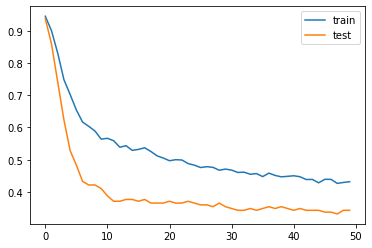

In [47]:
x_test2 = tf.keras.applications.efficientnet.preprocess_input(x_test)
y_test2 = tf.stack(y_test)

# evaluate the model
_, train_acc = model.evaluate(np.array(x_train), np.array(y_train), verbose=1)
_, test_acc = model.evaluate(np.array(x_test), np.array(y_test2), verbose=1)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
train_error = []
test_error = []

for accuracy in hist.history["accuracy"]:
    train_error.append(1-accuracy)
for accuracy in hist.history["val_accuracy"]:
    test_error.append(1-accuracy)

# plot training history
pyplot.plot(train_error, label='train')
pyplot.plot(test_error, label='test')
pyplot.legend()
pyplot.show()

In [52]:
y_pred = model.predict(np.array(x_test)) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


6/6 [==============================] - 2s 64ms/step
[[4 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 8 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [1 0 0 5 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 2 0 0 0 0 1 0 0 0 0 1 0 0 3 0]
 [0 0 1 0 0 3 1 0 1 0 0 0 0 0 1 2 0 0 0 0]
 [0 1 0 0 0 0 7 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 7 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 6 0 1 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 4 3 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 7 0 0 1 0 0]
 [0 1 0 0 1 2 0 1 2 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 8 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 2 0 1 0 0 5 0 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 5 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8]]
              precision    recall  f1-score   support

           0       0.80      0.5